In [1]:
import numpy as np
import scipy.stats
import scipy.fftpack
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import lds_utils, seq_utils, display_widgets

In [4]:
import ipywidgets as widgets
from IPython.display import display,clear_output

# Introduction

The goal of this exercise is part tutorial in discrete linear dynamical systems, part exploration of low frequency oscillatory dynamics, a feature that is increasingly found in datasets recorded from motor cortical regions of the brain (e.g. Churchland 2012). The tutorial part covers basics of discrete linear dynamical systems (part I) and a review of how the parameters of a dynamics model can be analyzed and visualized to better understand what spatiotemporal patterns the model is producing (part II). The next part then covers how to use discrete linear dynamical systems in practice as a data analysis tool (part III). Finally, part IV extends part III but specifically investigates what sorts of spatiotemporal patterns in data may give rise to low-freuqency oscillatory dynamics that have been increasingly reported in motor cortical electrophysiology data. 

# Part I: Behavior of Discrete Linear Dynamical Systems
In this part, we review analysis of discrete, linear dynamical systems and illustrate in 2D typical behaviors 

Consider the system:  

<center>$x_t = A x_{t-1}$ </center>

where $x_t$ is a 2x1 vector. In words, $A$ represents a linear transform, generating $x_t$ based only on the activity of $x_{t-1}$. Similarly, $x_{t-1} = A x_{t-2}$ and so $x_{t-1}$  is also generated from $x_{t-2}$ through the same linear transform $A$. By continuing to work backwards to solve for $x_t$, we arrive at the solution: 

<center>$x_t = A x_{t-1} = A (A x_{t-2}) = A(A(A x_{t-3})) = ... = A^t x_0$. </center>

Thus, $x_t$ is just the result of an initial condition $x_0$ propagated forward in time $t$ times by linear transform $A$. Note that sometimes a slightly different form of this expression used: 


<center>$dx = x_{t} - x_{t-1} = Ax_{t-1}$</center>

In fact we can re-write this equation in a similar form to the one we started with above: 

 <center>$x_{t} - x_{t-1} = Ax_{t-1}$</center>

<center>$x_t = Ax_{t-1} + x_{t-1} = (A+I)x_{t-1} = (A')x_{t-1}$</center>

where $A' = A+I$. So, what sort of trajectories through time can $A$ or $A'$ generate? Consider the following examples:

In [4]:
#### This displays a widget with 5 diffrent A matrix options### 
### Step 1) Select an A matrix from the dropdown menu ####
### Step 2) Initialize some initial conditions on the graph (can slide the "initial_x0" 
###      slider and click "Run Interact" many times to initialize many points)
### Step 3) Select how many time steps you'd like to propagate the initial conditions ahead 
###      with the "num_timepoints" slider. Then click "Run Interact"
### Can "clear" the graph at the bottom to try out a new A matrix 
box = display_widgets.interative_viewer_Amatrix_plot()
box.assemble_box()
display(box.box)

In the five examples, the dark bluepurple points are the $x_0$ conditions, and the green and yellow points are the $x_0$ conditions that have been propagated in time by $A$. These five examples exemplify A1) a sink, A2) an explosion A3) an inward spiral, A4) an outward spiral, and A5) a saddle. Broadly, these characterize the most common types of behavior that are observed given an $A$ matrix. We split these examples in two categories; a) **stable vs. unstable**, and b) **oscillatory vs. non-oscillatory**. In the above examples, example 1 and 3 exhibit stable behavior (not exploding), and examples 2 and 4 exhibit unstable behavior (exploding). Example 5 has one unstable and one stable direction. Examples 1,  2, and 5 exhibit non-oscillatory behavior, while examples 3 and 4 exhibit oscillatory behavior. 

While these plots are easy to make in 2D, sometimes we want to analyze the behavior of higher dimensional datasets which are hard to make and look at, and second may be composed of many different types of behaviors (i.e mixes of the above examples). How can we figure out what the dominant behavior of an NxN A matrix is without having to make tons of subplots and try to imagine high dimensional space?  

# Part II: Analyzing $A$ to infer dynamical behavior

Turns out that we can decompose the A matrix in a way that gives insight into the computations it performs. I won't review the concept of eigenvalues and eigenvectors here, but it is necessary to understand the next steps. Here is a great refresher: https://www.youtube.com/watch?v=PFDu9oVAE-g

So let's return to the solution for $x_t$: 
$x_t = A^t x_0$. Unless $A$ is the identity matrix or a zero matrix, presently its unclear what we should expect $A^t$ to do to $x_0$. In order to make this more clear, we'll decompose $A$. 

Let's assume that $A$ is a simple matrix $\in \mathbb{R}^{nxn}$, and so we can decompose it into $n$ distinct and linearly independent eigenvectors ($v_i \in \mathbb{C}^n, i = 1...n$) and respective non-zero eigenvalues ($\lambda_i \in \mathbb{C}^1, i = 1...n$). For each eigenvector and eigenvalue, we can write: 

<center> $ A v_i = \lambda_i v_i$ for all $i = 1...n$</center> 

Here, $v_i$ is an $ n x 1 $ vector. We can write $v_i$ as a column and horizontally stack up all the $v_i s$ to a large matrix we'll call $T$. Then we can also place the $\lambda_i$s on the diagonal of a matrix $\Lambda$.  This is written as: 

<center> $ A \begin{bmatrix} v_1 & v_2 & ... & v_n \end{bmatrix} = \begin{bmatrix} v_1 & v_2 & ... & v_n \end{bmatrix}\begin{bmatrix} \lambda_1 & 0 & ... & 0 \\ 0 & \lambda_2 & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_n \end{bmatrix}$</center> 

Or more simply as: 

<center> $A T = T \Lambda $</center> 

Since we assumed that $A$ was decomposible into $n$ linearly independent eigenvectors with non-zero eigenvalues, that's all we need to know to confirm that $T$ is an invertible matrix. We can then write: 

<center> $ A = T \Lambda T^{-1}$</center> 

Why is this useful? If we return to the solution $x_t = A^t x_0$, its hard to imagine what $A^t$ would look like without actually multiplying out $A$ all $t$ times. However, if replacing $A$ with $ T \Lambda T^{-1}$, makes the solution start to look more understandable: 

<center> $x_t = A^t x_0$</center> 

<center> $x_t = ( T \Lambda T^{-1})^t x_0 $</center> 

<center> $x_t = ( T \Lambda T^{-1}) ( T \Lambda T^{-1}) ... ( T \Lambda T^{-1}) x_0$</center> 

<center> $x_t =  T \Lambda T^{-1}  T \Lambda T^{-1}  ...  T \Lambda T^{-1}  x_0$</center> 

Now, if we look closely, we see that there a number of $T^{-1}T $s that would evaluate to the identity matrix. If we remove all the $T^{-1}T$s, we're left with:

<center> $x_t = T \Lambda \Lambda ... \Lambda T^{-1}  x_0$</center> 

<center> $x_t = T\Lambda^t T^{-1} x_0$</center> 

We can make this even easier to understand if we multipy both sides by $T^{-1} $ and define a new variable $z = T^{-1} x$ which is just a linear transform of $x$. Now, instead of studying the effects of $A$ operating on $x$, we can now think of $\Lambda$ operating on $z$. This particular linear transformation will make it easier for us to "see" what sorts of dynamical behavior $A$ generates. 

<center> $T^{-1} x_t = T^{-1} T \Lambda^t T^{-1}  x_0$</center> 

<center> $T^{-1} x_t = \Lambda^t T^{-1}  x_0$</center> 

<center>$z_t = \Lambda^t z_0$ after substituting $z = T^{-1} x$</center>

<center> $z_t = \begin{bmatrix} \lambda_1 & 0 & ... & 0 \\ 0 & \lambda_2 & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_n \end{bmatrix} ^{ t } z_0$</center> 

<center> $z_t = \begin{bmatrix} \lambda_1^t & 0 & ... & 0 \\ 0 & \lambda_2^t & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_n^t \end{bmatrix} z_0$</center> 

Now, this is something we can analyze easily! With an eigenvalue decomposition of A followed by a change of variable, we've ended up with a new dynamics matrix $\Lambda$ operating on variable $z$ such that each dimension of $z$ is only ever influenced by itself. In other words, all the dimensions aren't mixed together as they may have been if we looked at the A matrix operating on $x$. If we consider just a single dimension, $z^i$, we can now write: 

<center> $z_t^i = \lambda_i^t z^i_0$</center> 

A final manipulation allows us to analyze the effects of $\lambda_i^t$. Since $\lambda_i$ may be a complex number, $\lambda_i = a_i + b_i i$ (if real, then $b_i$ = 0), we can re-write $\lambda_i = r_i e^{\theta_i i}$ where $r_i = \sqrt{(a_i^2 + b_i^2 )}$ and $\theta_i = tan^{-1} (\frac{b}{a})$

<center> $z_t^i = (r_i e^{\theta_i i})^t z_0$ </center> 

<center> $z_t^i = (r_i^t e^{\theta_i i t}) z_0$</center> 

<center> $z_t^i = (r_i^t [ cos(\theta_i t) + i sin(\theta_i t) ] ) z_0$</center> 

This expression indicates that $z_t^i$ will exponentially grow or decay over time (dictated by the $r_i$ value), and will oscillate at a frequency dictated by the $\theta_i$ value. Thus the behavior of the $z_i$ dimension is fully defined by the magnitude ($r_i$) and angle ($\theta_i$) of the eigenvalue ($\lambda_i$). With each step of $t, r_i^t$ will decay if $ r_i < 1$, or will explode if $ r_i > 1$. Thus, we call $\lambda_i$ **stable** for $r_i \leq 1$, and $\lambda_i$ **unstable** for $r_i > 1$. For stable $r_i$, the **decay time** associated with $\lambda_i$ is typically computed as the amount of time needed for $r_i^t$ to decay from $1$ at $t = 0$ to $\frac{1}{e}$. This ends up being **decay time** = $-\frac{1}{ln(r_i)} * dt$

Next, we can determine if $\lambda_i$ is **non-oscillatory** if $\theta_i = 0$, or that $\lambda_i$ is **oscillatory** if $\theta_i \neq 0$. Further, if $\lambda_i$ is oscillatory, $\theta_i$ corresponds to radians / timestep completed. This can be converted to **frequency** in Hz by dividing by $2\pi$ and then dividing by the length of each timestep in units of seconds. 

In conclusion, we can determine the behavior of a dynamics matrix $A$ by just looking at a plot of all eigenvalues plotted on axes of **time decay** vs. **oscillation frequency**. Let's try out these plots for the above A matrices: 

In [5]:
### Same widget instructions as above, but here pay attention to the eigenvalue plot on the bottom right
box = display_widgets.interactive_viewer_Amat_pls_eigs()
box.assemble_box()
display(box.box)

A few things to note about the above plots: a) when there are unstable eigenvalues (i.e  A2, A4, and part of A5), the time-decay values are negative and aren't interpretable, and b) when there is an oscillatory eigenvalue (i.e. examples 3, 4) both eigenvalues have the same time decay but opposite signs for oscillation frequency. This is expected -- oscillatory behavior requires two dimensions, and so eigenvalues corresponding to oscillatory modes come as a pair of complex conjugates ($a+bi, a-bi$) yielding $\theta$ and $-\theta$. 

To get more intuition for how the eigenvalues capture dynamical behavior, we'll analyze a common type of A matrix --  rotation matrices. Rotation matrices in 2D are defined as $\begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix}$, where $\theta$ is the degrees that the rotation matrix rotates points. We can consider $\theta$ a frequency if we consider a single point multiplied by the rotatio matrix once as a rotation of $\theta$ degrees per timestep. Converting degrees to cycles and timesteps to seconds yields a frequency. Below, see how 2D rotation matrices of varying frequencies can be analyzed through their eigenvalues: 

In [13]:
#### Rotation matrices 
### Step 1: choose a rotation frequency and select "run interact"
### Step 2: observe the relationship between the rotation frequency you select and the computed eigenvalue
### Other parts of the widget are identical to above. 
### Note that for faster frequencies it may be easier to visualize just 1 initial x_0 over many timesteps; 
box = display_widgets.rotator()
box.assemble_box()
display(box.box)

# Part III: Fitting $A$ to observed datasets, and visualizing top dynamical dimensions of $A$

In the above examples, we generated 2D data according to a given $A$ matrix and initial condition $x_0$. All data we created was perfectly adherent to $A$, without any external influences. Now, we're going to consider the opposite case where instead of having $A$ and using it to generate data, we have lots of higher dimensional data, and we try to estimate $A$ and then analyze $A$ to tell us something about the dynamics of our data. 


We will generate some fake data, then fit an $A$ matrix to the data, quantify how well this $A$ matrix fits the data, and then plot the eigenspectrum. Note that going forward we will only concern ourselves with **stable** systems. 

In [18]:
## Generate fake data with this gui
## STEP 1: Adjust the sliders for f1,f2,f3 (frequencies used to generate the fake data) and 
##     click "interact manual" to update the plot of the data + eigenvalue spectrum; Can also
##     adjust the 'noise' to add more or less noise to the fake data. 
## STEP 2: Use the ymax slider to change the height of the yaxis -- will update automatically
box = display_widgets.fake_data_maker()
box.assemble_box()
display(box.box)

### Pay attention to how the frequencies (f1, f2, f3) show up in the data and the eigenvalues 
### Also notice how adding noise changes the R2 of the model, and influences the estimated "time decay" values of the 
### eigenvalues; 

Some notes about the above simulation: 
* To estimate an A matrix from data we can do a simple least squares multiple linear regression where  $x_{t-1}$ predicts $x_t$
* If the dimesionality of X is high, it can be challenging to fit A, since need to estimate $N^2$ entries. Methods for improving robust fits of A include ridge regression, dynamic mode decomposition (Tu, 2012), using least squares for sparse matrices, and others. 
* $R^2$ printed above indicates the "variance accounted for" by the model, or how much of $x_t$ does $x_{t-1}$ account for. Notice that when more noise is added to the model, the $R^2$ reduces because the A matrix is not able to capture as much of $x_{t}$.
* We can see above that the main frequencies $f_1, f_2, f_3$ that we put into the fake data are being captured by $A$, based on the eigenvalues of $A$.
* There are also a few non-oscillatory components (centered at zero). 
* It is good to remember that in this dataset, the timestep $dt$ is 0.01 sec, or 10 ms. Thus, any decays calculated to be less than 10ms are not making substantial predictions since they exhibit time decays faster than the passage of a single bin. 
* A key idea is that the eigenvalues with the longest time decays are the ones with properties that are most present in the data. The dynamics associated with eigenvalues with very short time decays are not strongly present in the data. 

We're now going to focus on visualizing the dynamics using a flow field representation. For a review on how to do this: https://www.youtube.com/watch?v=qlUr2Jc5O0g

The widget below is identical to the one above, but now with an extra set of plots on the bottom. These plots are called flow fields, and are a visual illustration of the dynamics that the eigenvalues are capturing. The flow fields plot variable $z_i $ vs. $z_j$. Remember that $z$ is just a linear transform of $x$, so you can think of these 2D plots as planes slicing through high dimensional space. Each arrow on the flow field plot illustrates a prediction for $z_{i,j}(t)$ given that $z_{i,j}(t-1)$ is at the particular point at the start of the arrow. These plots allow us to visualize what the $A$ matrix predicts for points falling on a particular plane. The length and color of the arrow corresponds to the magnitude of the change in $z$ that $A$ predicts. 

You can adjust the dimensions that are plotted against each other using the "dim" sliders. Plotting dimensions that have the same frequency (e.g. 10 Hz and -10 Hz) will show you a plane where the arrows will illustrate rotations. You can also adjust "cmax" for each plot, to adjust the max value of the colorbar. If the plot is mostly yellow, you'll want to increase cmax, whereas if its mostly blue, you'll want to decrease cmax. 

The black lines on the flow field pltos plot the first 1 second of simulated data. The red dot marks the start of the data. Notice which dimensions seem to capture the changes in data the best. 

In [25]:
### STEP 1: as above, generate some data using the f1, f2, f3, and noise sliders. 
### STEP 2: on the plots below, you'll notice "flow fields appear". 
###     These are plots of variable z_i vs. z_j 
### STEP 3: Adjust the dim sliders to plot different dimensions against one another, and 
###    the cmax sliders to adjust the color of the arrows. 

### Notice that some pairs will look like oscillations, some will show only decays ###
### Remember that python uses 'zero-indexing' 

### The title of the plot will tell you the time decay and frequency of oscillation of each of the eigenvalues
### associated with the dimensions you are plotting. Notice that their properties 
### match the eigenvalue plot above 

box = display_widgets.fake_data_flows()
box.assemble_box()
display(box.box)

# Part IV: Spatiotemporal Patterns With Rotational Dynamics

Now that we have the tools to analyze a linear dynamics matrix $A$ and to visualize the dominant modes of the dynamics capture by $A$, we now turn to exploring how low frequency rotational dynamics may emerge from spatiotemporal patterns of neural activity. Recent work has highlighted that neural activity patterns in motor cortical areas exhibit rotational dynamics in the range of 1-4 Hz (Churchland 2012, Hall 2014, Sussillo 2015). We examine a few types of spatiotemporal structure can give rise to oscillatory dynamics in this range. 

First, we consider the simplest case -- neurons oscillating at the specified low frequency

# Case I: Sinusoids

In the example below choose a frequency and number of neurons (in this section we refer to dimensions as "neurons") and then slide through the different ```t_offset``` conditions (value of ```t_offset``` is in seconds) for that frequency. For each condition, an $A$ matrix is fit and the corresponding eigenvalues are plotted. See how different temporal offsets influence the frequency of the eigenvalues. See what happens for 4 neurons oscillating at 5 Hz with a 0.1 sec offset, for example. 

In [29]:
box = display_widgets.sinuoids()
box.assemble_box()
display(box.box)

You can see from the above example, that as long as there is a non-zero ```t_offset``` between each neuron (that is not a multiple of half the cycle time), and sufficiently low noise, the $A$ matrix recovers the frequency that each neuron is oscillating at. In the case of 5 Hz and 0.1 offset, each neuron ends up having the same waveform as the first neuron either multiplied by 1 or -1, so this is also prevents the $A$ matrix from recovering frequency information. 

This is the most obvious structure giving rise to rotational dynamics -- sinusoidal firing patterns. However it is unusual to observe this type of oscillating neural activity in motor regions of the brain. A structure that is more commonly found are neurons that have monophasic or multiphasic patterns that are activated at preferred times during the behiavior -- what we loosely term "sequential activity". Below we explore how sequential activity may exhibit rotational dynamics as well.

# Case 2: Sequential Activity

Below we'll generate a sequence. We'll first consider the simple 2D case where each neuron exhibits a single "bump" at a slight time offset to one another. The single neuron activation is composed of a sine wave (frequency dictated by ```freq```) multiplied by a gaussian (standard deviation of the gaussian corresponds to the time needed for half a cycle to transpire ). ```t_offset``` determines the offset time (seconds) between individual neurons in the sequence.

## 2 neuron case: 

For the example below, the widget is constrained only produce 2 neurons. Set the frequency and noise level, and sweep through the ```t_offset``` and pay attention to how frequency of the eigenvalues change. Also observe the neural space plot in the middle that shows the 2D neural space and the trajectories through space that the neurons are tracing out. Starting with 2 hz and noise = 0.0 is a good place to start:  

In [30]:
box = display_widgets.mono_sequ2()
box.assemble_box()
display(box.box)

From the above examples you should be able to see that when the temporal offsets start to become larger and larger, the frequency of rotation found by the eigenvalues becomes lower than the frequency you set with the ```freq``` slider. Remember that the 2 x 2 $A$ matrix only has one 1 eigenvalue pair it can use to fit the data.  

Place the ```freq = 2```, ```t_offset = 0.12```, and ```noise = 0.05```. With long ```t_offset``` values, there are large regions of the signals (at the beginning and the end) when only one neuron is active. In this scenario the neural trajectory (plotted in the middle plot) does not abide the same dynamics as it does when both neurons are active in the middle of the sequence. The dynamics of these beginning and ending sections either decay towards the origin (in the beginning of the sequence -- can think of as 9 o'clock --> center), or away from the origin (at the end of the sequence -- can think of center --> 6 o'clock). Either way, instead of rotating counter-clockwise as the rest of the trajectory does, these trajectories seemingly resist the rotation. Their effect forces $A$ to lower the frequency estimate to try to fit both types of dynamics. 

Below, we'll explore how the ```t_offset``` parameter influences the frequency of the eigenvalues in the 2D case. This code snippet will also directly show you how the $A$ matrix is computed from data, and how the eigenvalue frequencies and time decays are computed. Evaluate the below function, and then use it visualize the effect of different ```t_offset``` on the resultant eigenvalue frequency. 

In [31]:
def plot_freq_as_fcn_dt(num_cycles_single_activation = 0.5):
    ### INPUT: num_cycles_single_activation = Set the standard deviation of the 
    ### gaussian convolved with the sinusoid in units of "fraction of cycles" 
    ### of the sinuoid. This parameter controls whether individual neural 
    ### activations are monophasic or multiphasic: 
    
    ### Main parameters to sweep ###
    N_neurons = 2 
    noise_level = 0.01

    ### timestep 
    dt = 0.001
    ## Generate plot / colors
    f, ax = plt.subplots(figsize=(8, 8))
    cols = plt.cm.viridis(np.linspace(0., 1, 11))

    ### Sweep through differnet underlying fundamental frequencies; 
    for freq in np.arange(1, 11, 1):

        ### Containers for mean frequency / sequence length ###
        mn_f = [];
        seq_cycle = []; 

        # Gaussian is set to half cycle, just like above: 
        gauss = num_cycles_single_activation/(freq)

        ### Set the time offsets as a function of frequency to make sure there's enough overlap
        quarter_cycle_time = (1/freq)*0.25
        fiftyth_cycle_time = (1/freq)*.1
        dt_offset = np.linspace(quarter_cycle_time, fiftyth_cycle_time, 100)

        ### For each DT ###
        for i_off, dt_off in enumerate(dt_offset):

            ### Get sequence data
            data = seq_utils.generate_seq(freq, gauss, dt_off, N_neurons=N_neurons, dt=dt)

            ### Add some noise 
            dT, dN = data.shape
            data_pls_noise = data + noise_level*np.random.randn(dT, dN)

            ### Estimate the A matrix 
            Aest = np.linalg.lstsq(data_pls_noise[:-1, :], data_pls_noise[1:, :], rcond=None)[0] 
            Aest = Aest.T

            ### Get the eigenvalue 
            ev, _ = np.linalg.eig(Aest)

            ### Get the freuqencies / time delays ###
            frequencies = np.angle(ev)/(2*np.pi*dt)
            time_decay = -1/np.log(np.abs(ev))*dt

            ### Get the positive frequencies ###
            ix_nonneg = np.nonzero(frequencies > 0)[0]

            if len(ix_nonneg) == 0:
                mn_f.append(np.nan)
            else:
                ### weighted average based on time decay ###
                mn_f.append(frequencies[ix_nonneg[0]])

            ### seq length ###
            seq_cycle.append(1./(dT*dt))

        ### Plot curve 
        ax.plot(seq_cycle, mn_f, '.', label='Freq %.1f Hz' %(freq), color = cols[int(freq)])

    ax.set_xlabel(' 1 / (Sequence Duration, sec.)')
    ax.set_ylabel('Eigenvalue Frequency (Hz)')
    f.legend()

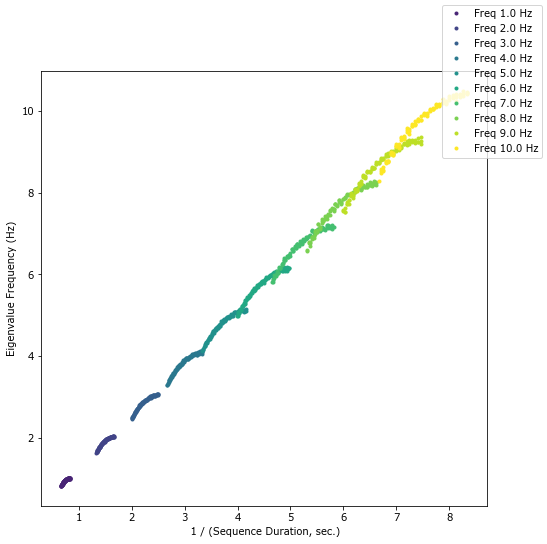

In [32]:
plot_freq_as_fcn_dt(num_cycles_single_activation = 0.5)

The above plot shows that as sequence duration increases (1/seq duration decreases), the frequency of the eigenvalues that are estimated from data decreases for a specific frequency. Further, the relationship between sequence duration and frequency is relatively constant across different underlying frequencies. This relationship may explain phenomenon observed in Hall 2014 (Fig. 2G and 2J) that demonstrate a relationship between speed of movements (perhaps a proxy for sequence duration), and frequency of rotation of neural features. The faster the movement, or smaller the sequence duration, or higher up on the x-axis of this plot, the higher the frequency represented. 

We stress that this effect is due to the manner in which the $A$ matrix is fit (using least squares). This method tries to account for as much variance as possible with the few eigenvalues it has, and so ends up adjusting the underlying frequency of the eigenvalues to minimize the errors. We also stress that an $A$ matrix alone cannot autonomously produce a sequence of activity (with an initial condition and multiplication by $A$ to produce each subsequent datapoint). Thus, this is purely a result of using this type of model / analysis to capture activity patterns in data that may be under many more influences than just an $A$ matrix. 

This effect is most prominent for 2D neurons that only exhibit a single cycle ("monophasic"). In the 2D case if we allow neurons to have multiphasic activity (> 1 cycle), this relationship is less drastic, and the frequency of the $A$ matrix does not drift far from the underlying frequency of the oscillating neurons. Below there are multiphasic neurons. We also show below the widget the same plot as above, but for a larger value of ```num_cycles_single_activation```. 

In [33]:
box = display_widgets.ploy_sequ2()
box.assemble_box()
display(box.box)

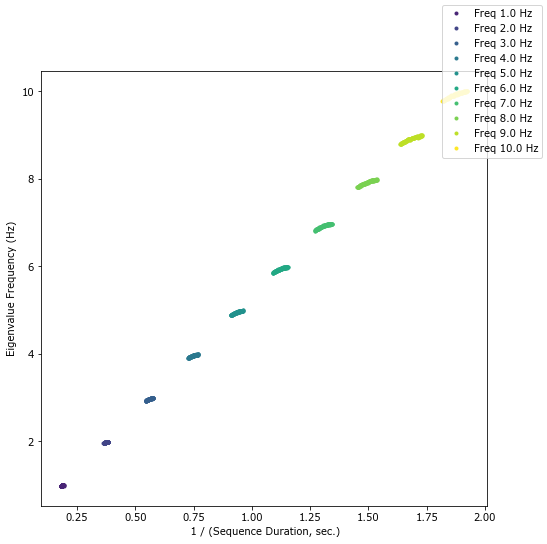

In [34]:
plot_freq_as_fcn_dt(num_cycles_single_activation = 2.5)

In the cases where the 2 neurons are multiphasic, most variance is going to be captured by having an eigenvalue pair that oscillates at the same frequency as the multiphasic neurons. In this case, "slowing down" the frequency will not contribute to helping explain the beginning or end parts where only one neuron is active. Again, this trend is a result of data fitting. 

### > 2 neurons 

So what happens when there are more than 2 neurons? Imagine the case of 4 neurons. This becomes interesting because now the $A$ matrix has 2 pairs of complex eigenvalues it can use to fit the data, not just one. Let's investigate what happens. Consider a similar case as above, where ```freq = 2```, ```noise =0.0```, and now ```N_neurons = 4 ``` and ```frac_sine_cycle = 2```. Now sweep the ```t_offset``` and observe how the eigenvalues change, as well as what the flow plots capture. Note that the red dot represents the start of the spatiotemporal pattern. 

In [35]:
box = display_widgets.flex_sequ_pls_flow()
box.assemble_box()
display(box.box)

For the most part, one pair of eigenvalues ($\lambda_0$ and $\lambda_1$) consistently stays around the underlying frequency (in the suggested example, 2 Hz), while the other one, which has a shorter time decay, shifts around in frequency. This second pair tends to be higher frequency for shorter values of ```t_offset```, and lower frequency for longer values of ```t_offset```. From looking at the flow field plots, it becomes clear that the second pair of eigenvalues is trying to estimate activity related to the onset of the sequence (red dot is start of the sequence). For smaller ```t_offset```s, the second eigenvalue pair is higher frequency, with rapidly moving activity in its flow field, whereas for larger values of ```t_offset```, the second eigenvalue pair is lower frequency. 

Below is code that plots the multiple eigenvalues for neural patterns that are either monophasic or multiphasic (depending on ```num_cycles_single_activation```)

In [36]:
def plot_freq_as_fcn_dt_multiphasic(num_cycles_single_activation = 0.5, N_neurons = 4):

    ### INPUTS: num_cycles_single_activation: Set the standard deviation of the gaussian 
    ### convolved with the sinusoid in units of "fraction of cycles" of the sinuoid. 
    ### This parameter controls whether individual neural activations are monophasic or multiphasic

    ### INPUT : N_neurons -- number of neurons in the simulation; 

    ### Main parameters to sweep ###
    noise_level = 0.0
    dt = .005; 
    frequencies = np.arange(1, 11, 1)

    ### For plotting 
    hf_freq = np.max([int(1), int(len(frequencies)/2.)])

    ## Generate plot / colors
    f, ax = plt.subplots(figsize=(15, 5), ncols = int(hf_freq), nrows = 2)
    cols = plt.cm.viridis(np.linspace(0., 1, len(frequencies)+1))


    ### Sweep through differnet underlying fundamental frequencies; 
    for i_f, freq in enumerate(frequencies):

        ### Full 
        gauss = 1./freq*num_cycles_single_activation

        ### Containers for mean frequency / sequence length ###
        mn_f = [];
        seq_l = []; 
        dt_ = []; 

        ### Set the time offsets as a function of frequency to make sure there's enough overlap
        half_cycle_time = (1/freq)*0.25
        hund_cycle_time = (1/freq)*.02
        dt_offset = np.linspace(hund_cycle_time, half_cycle_time, 100)


        ### For each DT ###
        for i_off, dt_off in enumerate(dt_offset):

            ### Get sequence data
            data = seq_utils.generate_seq(freq, gauss, dt_off, N_neurons=N_neurons, dt=dt)

            ### Get seq length: 
            mod = np.sum(np.abs(data), axis=1)
            mod_ix = np.nonzero(mod)[0]

            ### Step backward:
            i = len(mod_ix) - 1
            while mod[mod_ix[i]] == 0:
                i -= i
            seq_length = mod_ix[i]*dt

            ### Add some noise 
            data_pls_noise = data + noise_level*np.random.randn(data.shape[0], data.shape[1])

            ### Estimate the A matrix 
            Aest = np.linalg.lstsq(data_pls_noise[:-1, :], data_pls_noise[1:, :], rcond=None)[0] 
            Aest = Aest.T

            ### Get the eigenvalue 
            ev, _ = np.linalg.eig(Aest)

            ### Get the freuqencies / time delays ###
            frequencies = np.angle(ev)/(2*np.pi*dt)
            time_decay = -1/np.log(np.abs(ev))*dt

            ### Get the positive frequencies ###
            ix_nonneg = np.nonzero(np.logical_and(frequencies > 0, frequencies < 50))[0]

            ### seq length ###
            seq_l.append(seq_length)
            dt_.append(dt_off)

            ### Plot curve 
            rwz = int(i_f/hf_freq)
            clz = int(i_f%hf_freq)

            ax[rwz, clz].plot([dt_off]*len(ix_nonneg), frequencies[ix_nonneg], '.', color=cols[int(freq)])

        xmin = np.min(dt_)
        xmax = np.max(dt_)

        ax[rwz, clz].set_xlabel('DT Offset (sec)')
        ax[rwz, clz].set_ylabel('Freq. (Hz)')
        ax[rwz, clz].set_title('Freq %d' %(freq))
        sd = np.arange(xmin, xmax, .01)

        ## Sequence duration ###
        ax[rwz, clz].hlines(freq, xmin, xmax, 'k')
        #ax[rwz, clz].plot(dt_, 0.25*(1./N_neurons)*1./np.hstack((dt_)), 'k--')

    f.tight_layout()


In the below plot, vary the monophasic vs. mulitphasic balance (via ```num_cycles_single_activation```, and the number of neurons, and see how eigenvalue frequencies change as a function of ```t_offsets```). 

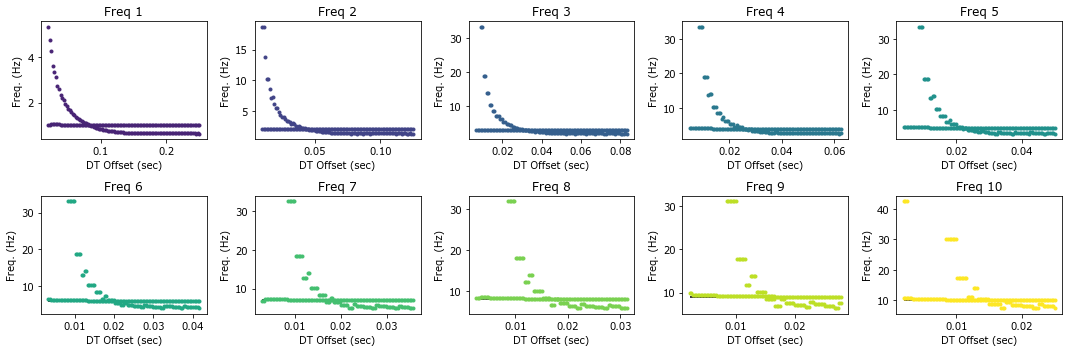

In [39]:
plot_freq_as_fcn_dt_multiphasic(num_cycles_single_activation = 2.5, N_neurons = 4)

What we can see from above is that when DT offset is low, meaning that the time between onset of each neurons' activation pattern is short, higher frequencies show up in the second pair of eigenvalues, likely to try to capture dynamics associated with the rapid (high frequency) onset of neural activity. Note that one eigenvalue pair is always associated with the underlying frequency (horizontal black line) of the activations, especially in the multiphasic case. 

Summary of what we've found: 

*   Sinusoids can give low frequency rotational oscillations in a fairly trivial way, i.e if there is a non-zero offset between two low frequency sine waves (Case I) 
*   Sequential activation of 2-neuron activity can also give low frequency rotational oscillations where frequency is influenced by the shape of the individual neural activation, as well as the offset time between each neural activation. 
*   Longer 2-neuron sequences, or longer time in between each neuron's onset yield lower frequency eigenvalues. 
*   Multiphasic 2-neuron sequences have eigenvalue frequencies that are less influenced by the onset time and are more consistently related to the frequency that dictates the individual neural activation. 

*   In higher-dimensional sequences, one pair of eigenvalues corresponds to the underlying freuqency of activation pattern, while other eigenvalue pairs capture dynamics related to temporally delayed onset of neural activity. Smaller offset times result in higher frequencies, whereas longer offset times result in lower frequencies. 

*   Overall, these trends support that when using dynamics to capture spatiotemporal activity patterns, there are variable ways in which "low frequency" oscillations can manifest, especially when there is noise in the data. Simple seqeuential structures (case II) may exhibit eigenvalue distributions similar to continuously oscillating sinusoids plus noise (case I), making it challenging to infer underlying spatiotemporal structure from analysis of dynamics alone. 

* Finally, the trends observed in part IV are a result of using a least squares method, a fairly common method, of fitting the $A$ matrix to data that imperfectly fits a dynamical system. Other methods of fitting $A$ may not exhibit the same results. Further, this was not an exhaustive search -- other spatiotemporal structures not explored here may exhibit low-frequency dynamics as well. 


# Conclusion

The objective of this exercise was to highlight the simple, discrete linear dynamical system as an analysis tool. Although a simple linear regression, the tool enables identification of spatial modes (eigenvectors) exhibiting consistent temporal structure (eigenvalues), and may be expecially useful in cases where data is expected to be lower dimensional and exhibit predictable temporal structure. 

Given the recent emphasis on rotational dynamics in motor cortical datasets during stereotyped behaviors reported in literature, we dedicate the final section to exploring what types of spatiotemporal patterns could produce these features. We uncover that low frequency modes can be generated by oscillations with a phase offset (case 1) or monophasic or multiphasic sequences with specific temporal offsets (case 2). 